Gordon Pye chose 8% as the discount rate based on its performance.

He (appears to have) looked average withdrawal (as a percentage of the initial portfolio) at ages 65-100 and decided
that 8% gave the highest withdrawal at each point along the spectrum.

He mentions 10,000 replications. I take that to mean for each rate, he ran a 10,000 iteration Monte Carlo analysis and then created averages at each age.

Pye uses a mean of .07 and a standard deviation of .16 in his Monte Carlo. He uses normal -- not lognormal -- for his Monte Carlo. He says, "Tests using the lognormal distribution show little effect on the results. Also, using the log- normal distribution is not conservative, as it reduces the chances of large negative returns."

He doesn't include fixed income and claims that, "Including some fixed income issues in the portfolio has little effect on the results of the simulations."

In [1]:
import itertools
import pandas
import montecarlo
import dms
import simulate
from harvesting import make_rebalancer
from withdrawal import RetrenchmentRule, VPW
from pprint import pprint

%precision 3
%pdb off

Automatic pdb calling has been turned OFF


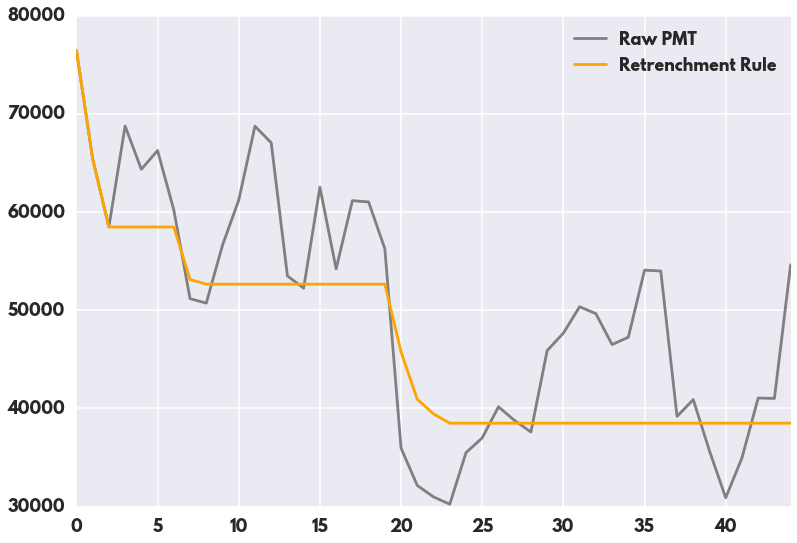

In [2]:
%matplotlib inline
import plot

s1, s2 = itertools.tee(montecarlo.NormalReturns(0.07, .16))

x2 = simulate.withdrawals(s2,
                         withdraw=lambda p, s: RetrenchmentRule(p, s, only_down=False),
                         years=45,
                         portfolio=(600000,400000),
                         harvesting=make_rebalancer(.6))
plot.seaborn.tsplot([float(n.withdraw_r) for n in x2], color='gray', legend=True, condition='Raw PMT')

x1 = simulate.withdrawals(s1,
                         withdraw=lambda p, s: RetrenchmentRule(p, s),
                         years=45,
                         portfolio=(600000,400000),
                         harvesting=make_rebalancer(.6))
plot.seaborn.tsplot([float(n.withdraw_r) for n in x1], color='orange', legend=True, condition='Retrenchment Rule')

In [3]:
def make_frame():
    return pandas.DataFrame(columns=[65, 70, 75, 80, 85, 90, 95, 100])

def sim(rate, iterations, series):
    years_to_go = 36
    
    pd = make_frame()

    for i in range(iterations):
        s = simulate.withdrawals(series,
                                 harvesting=make_rebalancer(1),
                                 withdraw=lambda p, h: RetrenchmentRule(p, h, discount_rate=rate),
                                 years=years_to_go)
        wds = [n.withdraw_pct_orig for n in s]
        data = wds[:(101-65):5]
        pd.loc[i] = data

    yearly = {}
    for i in range(65, 101, 5):
        yearly[i] = pd[i].median()
    return yearly

def extract_dms(k):
    e = k['equities']
    return (e[0] / 100.0, e[2] / 100.0)

In [4]:
sims = {
    'pye' : montecarlo.NormalReturns(0.07, .16),
#    'blanchett_100_historical' : montecarlo.historical[100],
#    'blanchett_60_historical' : montecarlo.historical[60],
#    'blanchett_40_historical' : montecarlo.historical[40],
#    'blanchett_60_conservative' : montecarlo.conservative[60],
#    'australia' : montecarlo.NormalReturns(*extract_dms(dms.australia)),
#    'us' : montecarlo.NormalReturns(*extract_dms(dms.us)),
#    'world' : montecarlo.NormalReturns(*extract_dms(dms.world)),
#    'uk' : montecarlo.NormalReturns(*extract_dms(dms.uk)),
#    'japan' : montecarlo.NormalReturns(*extract_dms(dms.japan)),
#    'europe' : montecarlo.NormalReturns(*extract_dms(dms.europe)),
#    'south africa' : montecarlo.NormalReturns(*extract_dms(dms.south_africa)),
#    'ex-us' : montecarlo.NormalReturns(*extract_dms(dms.ex_us))
}

In [5]:
def run_all(loops, display=False, to_csv=False):
    for label in sorted(sims.keys()):
        print('[', label, ']', end='\t')
        pd = make_frame()
        print('Starting simulations:', end=' ')
        for rate in range(2, 13, 1):
            print(rate, end=' ')
            pd.loc[rate] = sim(rate/100.0, loops, sims[label])
        print()
        if display:
            print(pd)
        if to_csv:
            pd.to_csv('RDR-%s.csv' % label)

%time run_all(25, to_csv=False)

[ pye ]	Starting simulations: 2 3 4 5 6 7 8 9 10 11 12 
CPU times: user 3.21 s, sys: 115 ms, total: 3.32 s
Wall time: 4.34 s


In [6]:
from metrics import hreff_cew_floor
from decimal import Decimal

hreff4 = lambda cfs: float(hreff_cew_floor(Decimal('2'), [Decimal(c * 100) for c in cfs]))

if False:
    pd = pandas.read_csv('pye.csv')
    for index, row in pd.iterrows():
        #print(int(row['Discount Rate']), end=' ')
        print(hreff4(row[1:])/100)